In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")


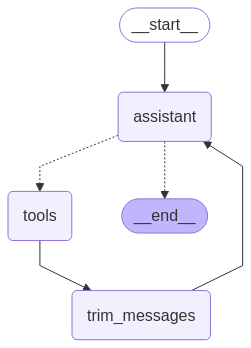

In [7]:

from agents.fromScratch_player.creator_agent import CreatorAgent
from catanatron import Color
langPlayer = CreatorAgent()
langPlayer.print_react_graph()

In [ ]:
from langchain_openai import AzureChatOpenAI
from langgraph.graph import MessagesState, START, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import RemoveMessage
from langchain_community.tools.tavily_search import TavilySearchResults


llm = AzureChatOpenAI(
    model="gpt-4o",
    azure_endpoint="https://gpt-amayuelas.openai.azure.com/",
    api_version = "2024-12-01-preview"
)
tools = []
llm_with_tools = llm.bind_tools(tools)
        
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"][:-10])]}

# def trim_messages(state: MessagesState):
#     # Delete all but the specified most recent messages
#     delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-10]]
#     return {"messages": delete_messages}


builder = StateGraph(MessagesState)

# Define nodes: these do the work
# builder.add_node("trim_messages", trim_messages)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")


#         builder = StateGraph(MessagesState)
# builder.add_node("trim_messages", trim_messages)
# builder.add_node("assistant", assistant)
# builder.add_node("tools", ToolNode(tools))

# builder.add_edge(START, "assistant")
# builder.add_conditional_edges(
#     "assistant",
#     # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
#     # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
#     tools_condition,
# )
# builder.add_edge("tools", "trim_messages")
# builder.add_edge("trim_messages", "assistant")

react_graph = builder.compile(checkpointer=MemorySaver())

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`